In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.examples.tutorials.mnist import input_data

import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
n_train_sample = 55000
batch_size = 256
epochs = 200
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [3]:
(train_data, train_Y), (test_data, test_Y) = mnist.load_data()
train_data = np.expand_dims(train_data, axis=-1)/255
test_data = np.expand_dims(test_data, axis=-1)/255

train_label = np.zeros((len(train_Y), num_classes))
train_label[np.arange(len(train_Y)), train_Y] = 1
test_label = np.zeros((len(test_Y), num_classes))
test_label[np.arange(len(test_Y)), test_Y] = 1

In [4]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,train_data,test_size=0.2,random_state=13)

# Train autoencoder

In [7]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [8]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [9]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
__________

In [8]:
autoencoder_train = autoencoder.fit(
    train_X,
    train_ground,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_ground)
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 9s 185us/step - loss: 0.0437 - val_loss: 0.01906 - ETA: 3s
Epoch 2/200
48000/48000 [==============================] - 7s 142us/step - loss: 0.0117 - val_loss: 0.0141
Epoch 3/200
48000/48000 [==============================] - 7s 142us/step - loss: 0.0076 - val_loss: 0.0139
Epoch 4/200
48000/48000 [==============================] - 7s 142us/step - loss: 0.0061 - val_loss: 0.0098
Epoch 5/200
48000/48000 [==============================] - 7s 142us/step - loss: 0.0050 - val_loss: 0.0057
Epoch 6/200
48000/48000 [==============================] - 7s 142us/step - loss: 0.0047 - val_loss: 0.0045
Epoch 7/200
48000/48000 [==============================] - 7s 142us/step - loss: 0.0038 - val_loss: 0.0078
Epoch 8/200
48000/48000 [==============================] - 7s 143us/step - loss: 0.0036 - val_loss: 0.0034
Epoch 9/200
48000/48000 [==============================] - 7s 143us/step - loss: 0.

Epoch 76/200
48000/48000 [==============================] - 7s 143us/step - loss: 9.1584e-04 - val_loss: 0.0015
Epoch 77/200
48000/48000 [==============================] - 7s 143us/step - loss: 9.0540e-04 - val_loss: 0.0015
Epoch 78/200
48000/48000 [==============================] - 7s 143us/step - loss: 8.9417e-04 - val_loss: 0.0015
Epoch 79/200
48000/48000 [==============================] - 7s 143us/step - loss: 8.9524e-04 - val_loss: 0.0016
Epoch 80/200
48000/48000 [==============================] - 7s 143us/step - loss: 8.8023e-04 - val_loss: 0.0015
Epoch 81/200
48000/48000 [==============================] - 7s 143us/step - loss: 8.8030e-04 - val_loss: 0.0016
Epoch 82/200
48000/48000 [==============================] - 7s 143us/step - loss: 8.7497e-04 - val_loss: 0.0015
Epoch 83/200
48000/48000 [==============================] - 7s 143us/step - loss: 8.5879e-04 - val_loss: 0.0013
Epoch 84/200
48000/48000 [==============================] - 7s 143us/step - loss: 8.5947e-04 - val_loss:

In [9]:
autoencoder.save_weights('autoencoder.h5')

# Load pre-trained autoencoder

In [11]:
autoencoder.load_weights("autoencoder.h5")
print("Loaded model from disk")

Loaded model from disk


In [12]:
# split train/test for classifier
train_X, valid_X, train_label, valid_label = train_test_split(train_data, train_label, test_size=0.2, random_state=13)

In [13]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [14]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [15]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [16]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [20]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [17]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [18]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 64)        18496     
__________

In [19]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 10s 203us/step - loss: 0.1419 - acc: 0.9589 - val_loss: 0.0778 - val_acc: 0.9803
Epoch 2/100
48000/48000 [==============================] - 8s 169us/step - loss: 0.0385 - acc: 0.9889 - val_loss: 0.0680 - val_acc: 0.9843
Epoch 3/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0229 - acc: 0.9935 - val_loss: 0.0849 - val_acc: 0.9801
Epoch 4/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0302 - acc: 0.9922 - val_loss: 0.0622 - val_acc: 0.9864
Epoch 5/100
48000/48000 [==============================] - 8s 167us/step - loss: 0.0211 - acc: 0.9939 - val_loss: 0.0685 - val_acc: 0.9846
Epoch 6/100
48000/48000 [==============================] - 8s 169us/step - loss: 0.0196 - acc: 0.9951 - val_loss: 0.0612 - val_acc: 0.9855
Epoch 7/100
48000/48000 [==============================] - 8s 169us/step - loss: 0.0229 - acc: 0.9939 - val_loss: 0

48000/48000 [==============================] - 8s 176us/step - loss: 0.0066 - acc: 0.9987 - val_loss: 0.0893 - val_acc: 0.9891
Epoch 60/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0077 - acc: 0.9986 - val_loss: 0.0677 - val_acc: 0.9911
Epoch 61/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0566 - val_acc: 0.9923
Epoch 62/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0776 - val_acc: 0.9911
Epoch 63/100
48000/48000 [==============================] - 8s 175us/step - loss: 0.0043 - acc: 0.9991 - val_loss: 0.0648 - val_acc: 0.9927
Epoch 64/100
48000/48000 [==============================] - 8s 170us/step - loss: 0.0054 - acc: 0.9993 - val_loss: 0.0745 - val_acc: 0.9903
Epoch 65/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0072 - acc: 0.9989 - val_loss: 0.0853 - val_acc: 0.9886
Epoch 66/100
48000/48000 [=======

In [20]:
full_model.save_weights('autoencoder_classification_fine_tuning.h5')

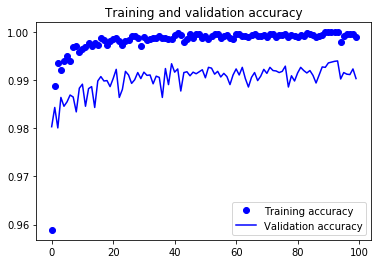

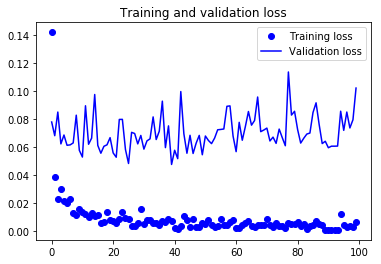

In [21]:
accuracy = classify_train.history['acc']
val_accuracy = classify_train.history['val_acc']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [22]:
test_eval = full_model.evaluate(test_data, test_label, verbose=0)

In [23]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.06899264513183828
Test accuracy: 0.9924


In [24]:
predicted_classes = full_model.predict(test_data)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [25]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(np.argmax(test_label, axis=1), predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.99      0.99      0.99       980
    Class 1       1.00      1.00      1.00      1135
    Class 2       0.99      0.99      0.99      1032
    Class 3       1.00      1.00      1.00      1010
    Class 4       1.00      0.98      0.99       982
    Class 5       0.99      0.99      0.99       892
    Class 6       0.99      0.99      0.99       958
    Class 7       0.98      1.00      0.99      1028
    Class 8       0.99      1.00      0.99       974
    Class 9       0.99      0.99      0.99      1009

avg / total       0.99      0.99      0.99     10000



# without autoencoder

In [8]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [9]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [10]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [11]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 64)        18496     
__________

In [15]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 10s 203us/step - loss: 0.1548 - acc: 0.9601 - val_loss: 0.1171 - val_acc: 0.9745
Epoch 2/100
48000/48000 [==============================] - 8s 169us/step - loss: 0.0557 - acc: 0.9851 - val_loss: 0.0936 - val_acc: 0.9808
Epoch 3/100
48000/48000 [==============================] - 8s 169us/step - loss: 0.0475 - acc: 0.9872 - val_loss: 0.0691 - val_acc: 0.9818
Epoch 4/100
48000/48000 [==============================] - 8s 173us/step - loss: 0.0367 - acc: 0.9901 - val_loss: 0.0484 - val_acc: 0.9886
Epoch 5/100
48000/48000 [==============================] - 8s 174us/step - loss: 0.0350 - acc: 0.9901 - val_loss: 0.0619 - val_acc: 0.9865
Epoch 6/100
48000/48000 [==============================] - 8s 170us/step - loss: 0.0251 - acc: 0.9928 - val_loss: 0.0491 - val_acc: 0.9874
Epoch 7/100
48000/48000 [==============================] - 8s 170us/step - loss: 0.0274 - acc: 0.9919 - val_loss: 0

In [16]:
full_model.save_weights('autoencoder_classification_no_autoeocoder.h5')

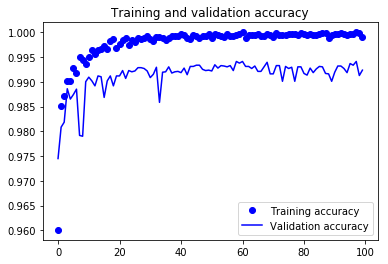

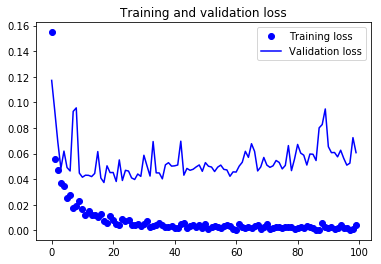

In [17]:
accuracy = classify_train.history['acc']
val_accuracy = classify_train.history['val_acc']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
test_eval = full_model.evaluate(test_data, test_label, verbose=0)

In [19]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.05110301081878258
Test accuracy: 0.993


In [20]:
predicted_classes = full_model.predict(test_data)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [21]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(np.argmax(test_label, axis=1), predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       1.00      1.00      1.00       980
    Class 1       1.00      0.99      0.99      1135
    Class 2       1.00      0.99      0.99      1032
    Class 3       0.99      0.99      0.99      1010
    Class 4       1.00      0.99      0.99       982
    Class 5       0.99      0.99      0.99       892
    Class 6       0.99      0.99      0.99       958
    Class 7       0.99      0.99      0.99      1028
    Class 8       1.00      0.99      0.99       974
    Class 9       0.99      0.99      0.99      1009

avg / total       0.99      0.99      0.99     10000



# Note

--> training classifier with autoencoder plus fine-tuning

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 10s 203us/step - loss: 0.1419 - acc: 0.9589 - val_loss: 0.0778 - val_acc: 0.9803
Epoch 2/100
48000/48000 [==============================] - 8s 169us/step - loss: 0.0385 - acc: 0.9889 - val_loss: 0.0680 - val_acc: 0.9843
Epoch 3/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0229 - acc: 0.9935 - val_loss: 0.0849 - val_acc: 0.9801
Epoch 4/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0302 - acc: 0.9922 - val_loss: 0.0622 - val_acc: 0.9864
Epoch 5/100
48000/48000 [==============================] - 8s 167us/step - loss: 0.0211 - acc: 0.9939 - val_loss: 0.0685 - val_acc: 0.9846
Epoch 6/100
48000/48000 [==============================] - 8s 169us/step - loss: 0.0196 - acc: 0.9951 - val_loss: 0.0612 - val_acc: 0.9855
Epoch 7/100
48000/48000 [==============================] - 8s 169us/step - loss: 0.0229 - acc: 0.9939 - val_loss: 0.0614 - val_acc: 0.9869
Epoch 8/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0126 - acc: 0.9969 - val_loss: 0.0628 - val_acc: 0.9865
Epoch 9/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0113 - acc: 0.9971 - val_loss: 0.0827 - val_acc: 0.9834
Epoch 10/100
48000/48000 [==============================] - 8s 174us/step - loss: 0.0156 - acc: 0.9958 - val_loss: 0.0575 - val_acc: 0.9883
Epoch 11/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0138 - acc: 0.9965 - val_loss: 0.0528 - val_acc: 0.9892
Epoch 12/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0121 - acc: 0.9969 - val_loss: 0.0894 - val_acc: 0.9846
Epoch 13/100
48000/48000 [==============================] - 8s 173us/step - loss: 0.0100 - acc: 0.9976 - val_loss: 0.0619 - val_acc: 0.9882
Epoch 14/100
48000/48000 [==============================] - 8s 169us/step - loss: 0.0127 - acc: 0.9971 - val_loss: 0.0663 - val_acc: 0.9887
Epoch 15/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0105 - acc: 0.9977 - val_loss: 0.0975 - val_acc: 0.9843
Epoch 16/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0110 - acc: 0.9972 - val_loss: 0.0611 - val_acc: 0.9898
Epoch 17/100
48000/48000 [==============================] - 8s 173us/step - loss: 0.0060 - acc: 0.9987 - val_loss: 0.0555 - val_acc: 0.9908
Epoch 18/100
48000/48000 [==============================] - 8s 173us/step - loss: 0.0066 - acc: 0.9982 - val_loss: 0.0604 - val_acc: 0.9898
Epoch 19/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0135 - acc: 0.9972 - val_loss: 0.0615 - val_acc: 0.9899
Epoch 20/100
48000/48000 [==============================] - 8s 174us/step - loss: 0.0075 - acc: 0.9981 - val_loss: 0.0666 - val_acc: 0.9887
Epoch 21/100
48000/48000 [==============================] - 8s 169us/step - loss: 0.0068 - acc: 0.9985 - val_loss: 0.0557 - val_acc: 0.9903
Epoch 22/100
48000/48000 [==============================] - 9s 179us/step - loss: 0.0055 - acc: 0.9989 - val_loss: 0.0526 - val_acc: 0.9922
Epoch 23/100
48000/48000 [==============================] - 8s 169us/step - loss: 0.0082 - acc: 0.9981 - val_loss: 0.0796 - val_acc: 0.9864
Epoch 24/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0132 - acc: 0.9973 - val_loss: 0.0797 - val_acc: 0.9881
Epoch 25/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0092 - acc: 0.9981 - val_loss: 0.0582 - val_acc: 0.9918
Epoch 26/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0082 - acc: 0.9982 - val_loss: 0.0482 - val_acc: 0.9911
Epoch 27/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0035 - acc: 0.9992 - val_loss: 0.0704 - val_acc: 0.9893
Epoch 28/100
48000/48000 [==============================] - 8s 170us/step - loss: 0.0037 - acc: 0.9992 - val_loss: 0.0696 - val_acc: 0.9901
Epoch 29/100
48000/48000 [==============================] - 8s 170us/step - loss: 0.0053 - acc: 0.9988 - val_loss: 0.0622 - val_acc: 0.9916
Epoch 30/100
48000/48000 [==============================] - 8s 174us/step - loss: 0.0156 - acc: 0.9971 - val_loss: 0.0682 - val_acc: 0.9903
Epoch 31/100
48000/48000 [==============================] - 8s 169us/step - loss: 0.0052 - acc: 0.9990 - val_loss: 0.0584 - val_acc: 0.9917
Epoch 32/100
48000/48000 [==============================] - 8s 174us/step - loss: 0.0076 - acc: 0.9984 - val_loss: 0.0643 - val_acc: 0.9910
Epoch 33/100
48000/48000 [==============================] - 8s 175us/step - loss: 0.0078 - acc: 0.9986 - val_loss: 0.0658 - val_acc: 0.9911
Epoch 34/100
48000/48000 [==============================] - 8s 175us/step - loss: 0.0054 - acc: 0.9988 - val_loss: 0.0814 - val_acc: 0.9892
Epoch 35/100
48000/48000 [==============================] - 8s 175us/step - loss: 0.0053 - acc: 0.9988 - val_loss: 0.0653 - val_acc: 0.9908
Epoch 36/100
48000/48000 [==============================] - 8s 170us/step - loss: 0.0039 - acc: 0.9992 - val_loss: 0.0712 - val_acc: 0.9906
Epoch 37/100
48000/48000 [==============================] - 8s 175us/step - loss: 0.0068 - acc: 0.9988 - val_loss: 0.0927 - val_acc: 0.9864
Epoch 38/100
48000/48000 [==============================] - 8s 173us/step - loss: 0.0061 - acc: 0.9987 - val_loss: 0.0595 - val_acc: 0.9924
Epoch 39/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0088 - acc: 0.9985 - val_loss: 0.0750 - val_acc: 0.9891
Epoch 40/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0069 - acc: 0.9986 - val_loss: 0.0475 - val_acc: 0.9934
Epoch 41/100
48000/48000 [==============================] - 8s 175us/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0576 - val_acc: 0.9917
Epoch 42/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0015 - acc: 0.9997 - val_loss: 0.0516 - val_acc: 0.9923
Epoch 43/100
48000/48000 [==============================] - 8s 170us/step - loss: 0.0033 - acc: 0.9993 - val_loss: 0.0996 - val_acc: 0.9878
Epoch 44/100
48000/48000 [==============================] - 8s 170us/step - loss: 0.0106 - acc: 0.9979 - val_loss: 0.0694 - val_acc: 0.9916
Epoch 45/100
48000/48000 [==============================] - 8s 169us/step - loss: 0.0080 - acc: 0.9986 - val_loss: 0.0555 - val_acc: 0.9918
Epoch 46/100
48000/48000 [==============================] - 8s 175us/step - loss: 0.0025 - acc: 0.9996 - val_loss: 0.0683 - val_acc: 0.9909
Epoch 47/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0084 - acc: 0.9987 - val_loss: 0.0553 - val_acc: 0.9917
Epoch 48/100
48000/48000 [==============================] - 8s 174us/step - loss: 0.0024 - acc: 0.9995 - val_loss: 0.0627 - val_acc: 0.9913
Epoch 49/100
48000/48000 [==============================] - 8s 176us/step - loss: 0.0027 - acc: 0.9996 - val_loss: 0.0682 - val_acc: 0.9918
Epoch 50/100
48000/48000 [==============================] - 8s 173us/step - loss: 0.0060 - acc: 0.9988 - val_loss: 0.0544 - val_acc: 0.9922
Epoch 51/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0049 - acc: 0.9992 - val_loss: 0.0678 - val_acc: 0.9905
Epoch 52/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0077 - acc: 0.9986 - val_loss: 0.0646 - val_acc: 0.9927
Epoch 53/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0044 - acc: 0.9993 - val_loss: 0.0623 - val_acc: 0.9925
Epoch 54/100
48000/48000 [==============================] - 8s 175us/step - loss: 0.0026 - acc: 0.9996 - val_loss: 0.0663 - val_acc: 0.9912
Epoch 55/100
48000/48000 [==============================] - 8s 173us/step - loss: 0.0032 - acc: 0.9995 - val_loss: 0.0722 - val_acc: 0.9918
Epoch 56/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0081 - acc: 0.9987 - val_loss: 0.0725 - val_acc: 0.9907
Epoch 57/100
48000/48000 [==============================] - 8s 173us/step - loss: 0.0045 - acc: 0.9991 - val_loss: 0.0728 - val_acc: 0.9914
Epoch 58/100
48000/48000 [==============================] - 8s 173us/step - loss: 0.0041 - acc: 0.9994 - val_loss: 0.0890 - val_acc: 0.9908
Epoch 59/100
48000/48000 [==============================] - 8s 176us/step - loss: 0.0066 - acc: 0.9987 - val_loss: 0.0893 - val_acc: 0.9891
Epoch 60/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0077 - acc: 0.9986 - val_loss: 0.0677 - val_acc: 0.9911
Epoch 61/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0566 - val_acc: 0.9923
Epoch 62/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0776 - val_acc: 0.9911
Epoch 63/100
48000/48000 [==============================] - 8s 175us/step - loss: 0.0043 - acc: 0.9991 - val_loss: 0.0648 - val_acc: 0.9927
Epoch 64/100
48000/48000 [==============================] - 8s 170us/step - loss: 0.0054 - acc: 0.9993 - val_loss: 0.0745 - val_acc: 0.9903
Epoch 65/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0072 - acc: 0.9989 - val_loss: 0.0853 - val_acc: 0.9886
Epoch 66/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0034 - acc: 0.9993 - val_loss: 0.0755 - val_acc: 0.9906
Epoch 67/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0028 - acc: 0.9995 - val_loss: 0.0789 - val_acc: 0.9916
Epoch 68/100
48000/48000 [==============================] - 8s 175us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0957 - val_acc: 0.9899
Epoch 69/100
48000/48000 [==============================] - 8s 175us/step - loss: 0.0042 - acc: 0.9992 - val_loss: 0.0709 - val_acc: 0.9908
Epoch 70/100
48000/48000 [==============================] - 8s 175us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0721 - val_acc: 0.9922
Epoch 71/100
48000/48000 [==============================] - 8s 173us/step - loss: 0.0083 - acc: 0.9990 - val_loss: 0.0734 - val_acc: 0.9914
Epoch 72/100
48000/48000 [==============================] - 8s 170us/step - loss: 0.0038 - acc: 0.9995 - val_loss: 0.0642 - val_acc: 0.9927
Epoch 73/100
48000/48000 [==============================] - 8s 169us/step - loss: 0.0025 - acc: 0.9996 - val_loss: 0.0670 - val_acc: 0.9920
Epoch 74/100
48000/48000 [==============================] - 8s 175us/step - loss: 0.0055 - acc: 0.9990 - val_loss: 0.0625 - val_acc: 0.9919
Epoch 75/100
48000/48000 [==============================] - 8s 170us/step - loss: 0.0032 - acc: 0.9993 - val_loss: 0.0727 - val_acc: 0.9916
Epoch 76/100
48000/48000 [==============================] - 8s 173us/step - loss: 0.0038 - acc: 0.9994 - val_loss: 0.0666 - val_acc: 0.9918
Epoch 77/100
48000/48000 [==============================] - 9s 179us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0608 - val_acc: 0.9929
Epoch 78/100
48000/48000 [==============================] - 8s 170us/step - loss: 0.0057 - acc: 0.9991 - val_loss: 0.1136 - val_acc: 0.9886
Epoch 79/100
48000/48000 [==============================] - 8s 175us/step - loss: 0.0049 - acc: 0.9994 - val_loss: 0.0828 - val_acc: 0.9909
Epoch 80/100
48000/48000 [==============================] - 8s 173us/step - loss: 0.0046 - acc: 0.9992 - val_loss: 0.0855 - val_acc: 0.9898
Epoch 81/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0061 - acc: 0.9990 - val_loss: 0.0724 - val_acc: 0.9915
Epoch 82/100
48000/48000 [==============================] - 9s 179us/step - loss: 0.0037 - acc: 0.9994 - val_loss: 0.0627 - val_acc: 0.9927
Epoch 83/100
48000/48000 [==============================] - 8s 174us/step - loss: 0.0049 - acc: 0.9992 - val_loss: 0.0662 - val_acc: 0.9920
Epoch 84/100
48000/48000 [==============================] - 8s 175us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0692 - val_acc: 0.9915
Epoch 85/100
48000/48000 [==============================] - 8s 170us/step - loss: 0.0036 - acc: 0.9995 - val_loss: 0.0699 - val_acc: 0.9920
Epoch 86/100
48000/48000 [==============================] - 8s 173us/step - loss: 0.0044 - acc: 0.9994 - val_loss: 0.0846 - val_acc: 0.9910
Epoch 87/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0069 - acc: 0.9989 - val_loss: 0.0915 - val_acc: 0.9894
Epoch 88/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0046 - acc: 0.9992 - val_loss: 0.0761 - val_acc: 0.9911
Epoch 89/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0624 - val_acc: 0.9928
Epoch 90/100
48000/48000 [==============================] - 8s 174us/step - loss: 7.8512e-04 - acc: 0.9999 - val_loss: 0.0640 - val_acc: 0.9927
Epoch 91/100
48000/48000 [==============================] - 8s 171us/step - loss: 6.9934e-04 - acc: 0.9999 - val_loss: 0.0594 - val_acc: 0.9936
Epoch 92/100
48000/48000 [==============================] - 8s 175us/step - loss: 6.8069e-04 - acc: 1.0000 - val_loss: 0.0605 - val_acc: 0.9938
Epoch 93/100
48000/48000 [==============================] - 8s 175us/step - loss: 6.7340e-04 - acc: 1.0000 - val_loss: 0.0605 - val_acc: 0.9939
Epoch 94/100
48000/48000 [==============================] - 8s 175us/step - loss: 6.7233e-04 - acc: 1.0000 - val_loss: 0.0606 - val_acc: 0.9940
Epoch 95/100
48000/48000 [==============================] - 8s 173us/step - loss: 0.0123 - acc: 0.9979 - val_loss: 0.0855 - val_acc: 0.9902
Epoch 96/100
48000/48000 [==============================] - 8s 172us/step - loss: 0.0039 - acc: 0.9993 - val_loss: 0.0718 - val_acc: 0.9916
Epoch 97/100
48000/48000 [==============================] - 8s 169us/step - loss: 0.0029 - acc: 0.9996 - val_loss: 0.0849 - val_acc: 0.9912
Epoch 98/100
48000/48000 [==============================] - 8s 170us/step - loss: 0.0036 - acc: 0.9995 - val_loss: 0.0735 - val_acc: 0.9912
Epoch 99/100
48000/48000 [==============================] - 8s 174us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0794 - val_acc: 0.9923
Epoch 100/100
48000/48000 [==============================] - 8s 171us/step - loss: 0.0066 - acc: 0.9990 - val_loss: 0.1021 - val_acc: 0.9903